Baseline Results (Train/Test Split):
          Accuracy  Precision    Recall        F1  ROC-AUC
Baseline  0.964912   0.959459  0.986111  0.972603  0.99537


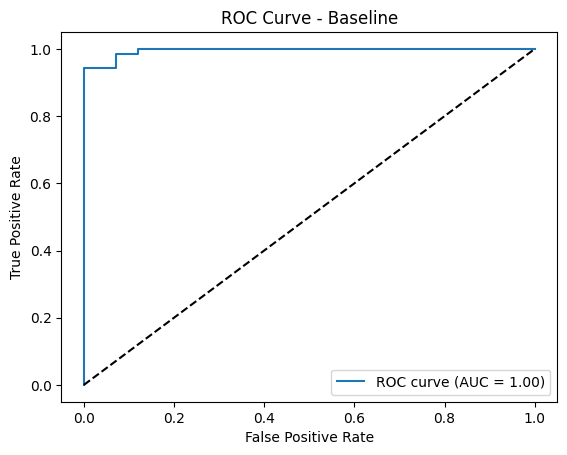


Cross-Validation Results Summary:
       fit_time  score_time  Accuracy  Precision    Recall        F1  \
mean  11.478969    0.008563  0.950737   0.952748  0.969000  0.960656   
std    2.422944    0.002657  0.021373   0.025881  0.019154  0.018418   
mean  10.547572    0.010456  0.954339   0.957230  0.971987  0.963964   
std    1.428198    0.003001  0.020889   0.033790  0.027975  0.016121   

       ROC-AUC           Method  
mean  0.990274            KFold  
std   0.011445            KFold  
mean  0.991901  StratifiedKFold  
std   0.005444  StratifiedKFold  


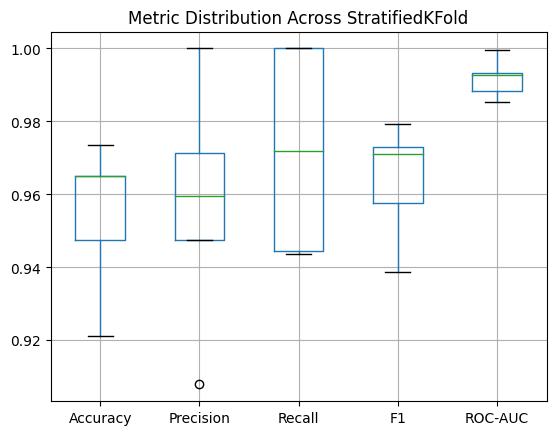

In [1]:
# =====================================
# 📌 Task 7: Cross-Validation & Evaluation
# =====================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
)

# -----------------------------
# 1. Load Dataset
# -----------------------------
data = load_breast_cancer()
X, y = data.data, data.target

# -----------------------------
# 2. Define Model
# -----------------------------
model = LogisticRegression(max_iter=5000, random_state=42)

# -----------------------------
# Helper Functions
# -----------------------------

def train_model(X_train, X_test, y_train, y_test, model):
    """Train and evaluate on single train/test split."""
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1]
    
    results = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1": f1_score(y_test, y_pred),
        "ROC-AUC": roc_auc_score(y_test, y_proba)
    }
    return results, y_test, y_proba


def cross_validate_model(X, y, model, cv, method="KFold"):
    """Perform cross-validation and return results as DataFrame."""
    scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
    results = cross_validate(model, X, y, cv=cv, scoring=scoring, return_train_score=False)
    
    df = pd.DataFrame(results)
    df = df.rename(columns={
        'test_accuracy': 'Accuracy',
        'test_precision': 'Precision',
        'test_recall': 'Recall',
        'test_f1': 'F1',
        'test_roc_auc': 'ROC-AUC'
    })
    
    summary = df.describe().loc[['mean','std']]
    summary['Method'] = method
    return summary


# -----------------------------
# 3. Train/Test Split Baseline
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

baseline_results, y_true, y_proba = train_model(X_train, X_test, y_train, y_test, model)
print("Baseline Results (Train/Test Split):")
print(pd.DataFrame(baseline_results, index=["Baseline"]))

# Plot ROC curve for baseline
fpr, tpr, _ = roc_curve(y_true, y_proba)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {baseline_results["ROC-AUC"]:.2f})')
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Baseline")
plt.legend()
plt.show()

# -----------------------------
# 4. Cross-Validation (KFold vs StratifiedKFold)
# -----------------------------
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
stratkfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_results_kf = cross_validate_model(X, y, model, cv=kfold, method="KFold")
cv_results_stratkf = cross_validate_model(X, y, model, cv=stratkfold, method="StratifiedKFold")

# -----------------------------
# 5. Comparison Table
# -----------------------------
comparison = pd.concat([cv_results_kf, cv_results_stratkf])
print("\nCross-Validation Results Summary:")
print(comparison)

# Optional: Boxplot of CV results
def plot_cv_distribution(X, y, model, cv, title):
    scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
    results = cross_validate(model, X, y, cv=cv, scoring=scoring)
    df = pd.DataFrame(results)
    df = df.rename(columns={
        'test_accuracy': 'Accuracy',
        'test_precision': 'Precision',
        'test_recall': 'Recall',
        'test_f1': 'F1',
        'test_roc_auc': 'ROC-AUC'
    })
    df.boxplot(column=['Accuracy','Precision','Recall','F1','ROC-AUC'])
    plt.title(title)
    plt.show()

plot_cv_distribution(X, y, model, stratkfold, "Metric Distribution Across StratifiedKFold")
